## Accessing DRCOG with the Planetary Computer STAC API

The [Denver Regional Council of Governments (DRCOG) Land Use/Land Cover (LULC)](https://drcog.org/services-and-resources/data-maps-and-modeling/regional-land-use-land-cover-project) 
datasets are developed in partnership with the Babbit Center for Land and Water Policy and the Chesapeake Conservancy's Conservation Innovation Center (CIC). DRCOG LULC includes 2018 data at 3.28ft (1m) resolution covering 1,000 square miles and 2020 data at 1ft resolution covering 6,000 square miles of the Denver, Colorado region. The classification data is derived from the USDA's 1m National Agricultural Imagery Program (NAIP) aerial imagery and leaf-off aerial ortho-imagery captured as part of the Denver Regional Aerial Photography Project (6in resolution everywhere except the mountainous regions to the west, which are 1ft resolution).

In this notebook, we'll demonstrate how to access and work with this data through the Planetary Computer. Documentation for this dataset is available at the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/drcog-lulc).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

In [1]:
import pystac_client
from pystac.extensions.item_assets import ItemAssetsExtension
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import requests
import planetary_computer
import rioxarray
import rich.table

### Query for data of interest

We'll query for 2018 DRCOG LULC data. 

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)

latitude = 39.55
longitude = -105.78
datetimes = ["2018"]

buffer = 0.6
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
items = dict()

for datetime in datetimes:
    print(f"Fetching {datetime}")
    search = catalog.search(collections=["drcog-lulc"], bbox=bbox, datetime=datetime)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Fetching 2018
Returned 13 Items


Each Item contains a single "data" asset with a URL to the location of the Asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). 

In [3]:
asset_href = items[0].assets["data"].href
print(asset_href)

https://landcoverdata.blob.core.windows.net/drcog-lulc/2018/DRCOG_2018_LULC_E3070000_N1710000.tif


### Available STAC assets and metadata

Let's check the available assets and metadata for a DRCOG LULC item. 

In [4]:
t = rich.table.Table("Key", "Title")
for k, asset in items[0].assets.items():
    t.add_row(k, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                           ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │ DRCOG LULC                      │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [5]:
t = rich.table.Table("Key", "Value")
for k, v in sorted(items[0].properties.items()):
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key            ┃ Value                                                                                          ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ created        │ 2022-07-15T15:22:33.322765Z                                                                    │
│ datetime       │ None                                                                                           │
│ description    │ 2018 Denver Regional Council of Governments (DRCOG) Land Use Land Cover (LULC) at 3.28ft (1m)  │
│                │ resolution                                                                                     │
│ end_datetime   │ 2018-12-31T23:59:59Z                                                                           │
│ mission        │ 2018 DRCOG LULC pilot study covering 1,000 square miles                                        │
│ proj:epsg      │ 2232                                                                                           │
│ proj:shape     │ [9144, 9144]                                                                                   │
│ proj:transform │ [3.28083333333333, 0.0, 3069998.36555848, 0.0, -3.280833333333333, 1740001.0677313006]         │
│ start_datetime │ 2018-01-01T00:00:00Z                                                                           │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

### Displaying the data

This dataset includes a preferred colormap mapping raster values to class names. The values and names are available in the collection's `item_asset` field.

In [6]:
# Classifications
collection = catalog.get_collection("drcog-lulc")
ia = ItemAssetsExtension.ext(collection)
x = ia.item_assets["data"]

class_names = {
    x["description"]: x["value"] for x in x.properties["classification:classes"]
}
class_values = {v: k for k, v in class_names.items()}

t = rich.table.Table("Description", "Raster value")
for k, v in class_names.items():
    t.add_row(k, str(v))
t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Description                            ┃ Raster value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Structures                             │ 1            │
│ Impervious Surfaces                    │ 2            │
│ Water                                  │ 3            │
│ Prairie/Grassland/Natural Ground Cover │ 4            │
│ Tree Canopy                            │ 5            │
│ Turf/Irrigated Land                    │ 6            │
│ Barren Land                            │ 7            │
│ Cropland                               │ 8            │
└────────────────────────────────────────┴──────────────┘

The Planetary Computer's Data API includes the colormap definition.

In [7]:
classmap = requests.get(
    f"https://pct-apis-staging.westeurope.cloudapp.azure.com/data/legend/classmap/{collection.id}"  # noqa: E501
).json()

colors = [matplotlib.colors.to_rgba([x / 255 for x in c]) for c in classmap.values()]
cmap = matplotlib.colors.ListedColormap(colors, name=collection.id)

ticks = np.linspace(1.5, 7.5, 8)
labels = [class_values.get(int(k), "nodata") for k in classmap]

Now we can read and plot the data.

In [8]:
item = items[0]
ds = rioxarray.open_rasterio(
    planetary_computer.sign(item.assets["data"]).href
).squeeze()

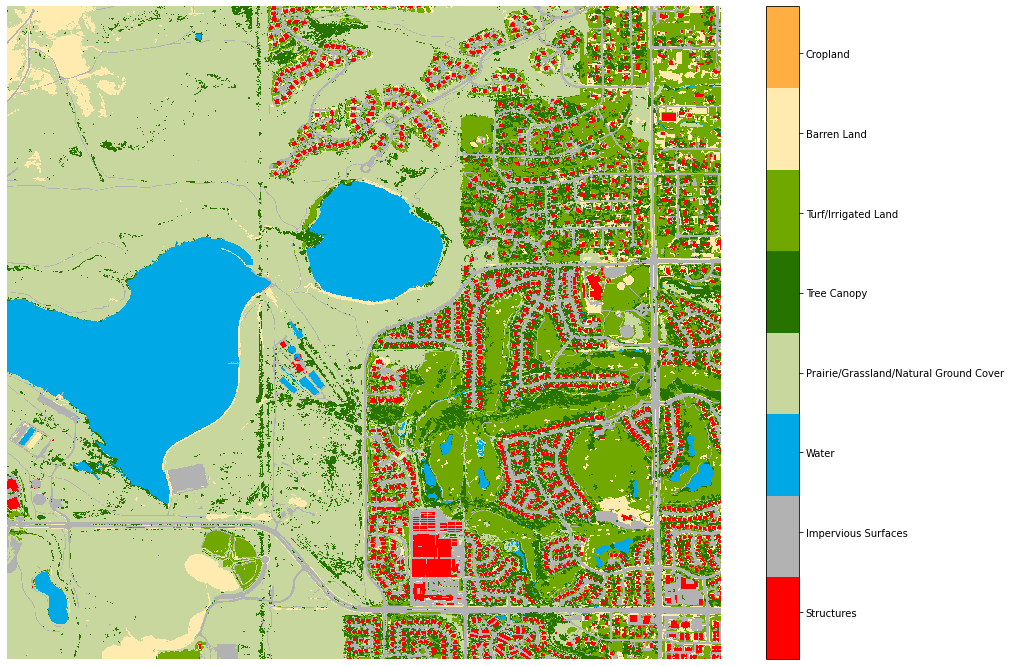

In [9]:
fig, ax = plt.subplots(figsize=(16, 12))

ds.isel(x=slice(3000, 6000), y=slice(3000, 6000)).plot(ax=ax, cmap=cmap, vmin=1, vmax=8)
ax.set_axis_off()
ax.set(title=None)

colorbar = fig.axes[1]
colorbar.set_yticks(ticks, labels=labels);